#### 计算复杂介质中的走时场 及 多条射线追踪

In [1]:
import pyfmm
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.ndimage import gaussian_filter

Text(0.5, 0, 'Velocity/km')

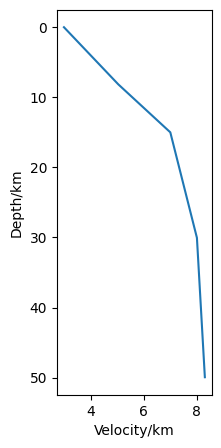

In [2]:
xarr = np.arange(0, 100, 0.08)
yarr = np.array([0.0])  # 二维情况
zarr = np.arange(0, 50, 0.05)

# 慢度场
slw  = np.ones((len(xarr), len(yarr), len(zarr)), dtype='f')

# 设定任意一维梯度背景速度，两列分别为深度和速度
vel1d = np.array([
    [0.0,  3.0],
    [8.0,  5.0],
    [15.0, 7.0],
    [30.0, 8.0],
    [50.0, 8.3],
])

# 插值1d分层速度
# _idxs = np.searchsorted(vel1d[:,0], zarr)
# vels = vel1d[_idxs, 1]
# OR
# 插值1d梯度速度 
vels = interpolate.interpn((vel1d[:,0],), vel1d[:,1], zarr)

# 绘制1d背景速度
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
ax.plot(vels, zarr)
ax.yaxis.set_inverted(True)
ax.set_ylabel("Depth/km")
ax.set_xlabel("Velocity/km")

In [3]:
XX, ZZ = np.meshgrid(xarr, zarr, indexing='ij')

np.random.seed(40)
# 生成一个随机二维数组（类似噪声）
vel = np.random.rand(len(xarr), len(zarr))*2-1

# 使用高斯滤波平滑处理，sigma值越大，图像越平滑
slw[...] = 1.0/(gaussian_filter(vel, sigma=50)*200 + vels[None,:])[:,None,:]

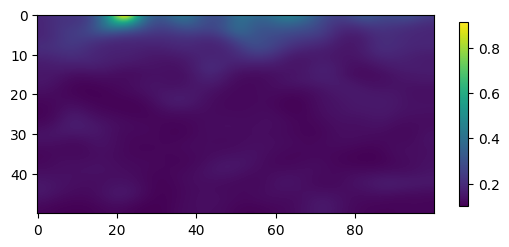

In [4]:
%matplotlib inline
# 慢度分布
fig, ax = plt.subplots(1, 1)
pcm = ax.pcolormesh(xarr, zarr, slw[:,0,:].T)
ax.set_aspect('equal')
ax.yaxis.set_inverted(True)
fig.colorbar(pcm, shrink=0.5)

In [5]:
srcloc = [0.0, 0.0, 0.0]

# FMM解
TT = pyfmm.travel_time_source(
    srcloc,
    xarr, yarr, zarr, slw)

In [6]:
def plot_raytracing(fig, ax, TT):
    # 水平方向
    for x in np.arange(5, 100, 5):
        # 射线追踪
        rcvloc = [x, 0, 0]

        travt, rays = pyfmm.raytracing(
            TT, srcloc, rcvloc, xarr, yarr, zarr, 0.1)
        ax.plot(rays[:,0], rays[:,2], c='r', lw=0.8, ls='--')

    # 竖直方向
    for z in np.arange(0, 50, 2.5):
        # 射线追踪
        rcvloc = [100, 0, z]

        travt, rays = pyfmm.raytracing(
            TT, srcloc, rcvloc, xarr, yarr, zarr, 0.1)
        ax.plot(rays[:,0], rays[:,2], c='b', lw=0.8, ls='--')



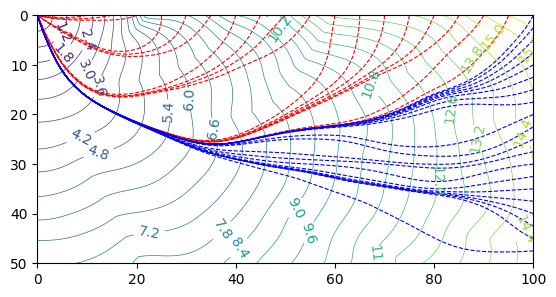

In [7]:
fig, ax = plt.subplots(1, 1)
cs = ax.contour(xarr, zarr, TT[:, 0, :].T, levels=30, linewidths=0.5)
ax.clabel(cs)

plot_raytracing(fig, ax, TT)

ax.set_aspect('equal')
ax.set_xlim(0, 100)
ax.set_ylim(0, 50)
ax.yaxis.set_inverted(True)

WARNING! For parallel FSM, maxLoops must set at least 2 (already changed).


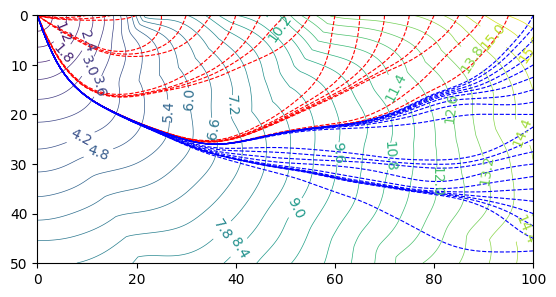

In [8]:
# FSM解
FSMTT = pyfmm.travel_time_source(
    srcloc,
    xarr, yarr, zarr, slw, useFSM=True, FSMparallel=True)

fig, ax = plt.subplots(1, 1)
cs = ax.contour(xarr, zarr, FSMTT[:, 0, :].T, levels=30, linewidths=0.5)
ax.clabel(cs)

plot_raytracing(fig, ax, FSMTT)

ax.set_aspect('equal')
ax.set_xlim(0, 100)
ax.set_ylim(0, 50)
ax.yaxis.set_inverted(True)